# Evaluating the models

In [1]:
from pathlib import Path
import random
import pandas as pd
import numpy as np
import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import umap
import hdbscan
from metrics import ACC, DBCV

import torch
from torch import nn
from torch import Tensor
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import transforms
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.datasets.vision import VisionDataset

from typing import Any, Tuple
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import MinMaxScaler

from trainer import trainer
from dataset.darksound import Darksound
from dataset.sampler import TaskSampler

from networks.protonet import PrototypicalNetworks
from networks.matchnet import MatchingNetworks
from networks.relatnet import RelationNetworks

import warnings
warnings.filterwarnings("ignore")

Set the seed for all random packages that could possibly be used

In [2]:
from config import load_config
CONFIG_FILE = 'config.yaml'
params = load_config(CONFIG_FILE)

# Set the seed for all random packages that could possibly be used
random_seed = params['RANDOM_SEED']
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Loading the pre-trained model

Before using the pre-trained models, one must preprocess the spectrogram (resize with right resolution/interpolation, apply inference transforms, rescale the values etc). There is no standard way to do this as it depends on how a given model was trained. It can vary across model families, variants or even weight versions. Using the correct preprocessing method is critical and failing to do so may lead to decreased accuracy or incorrect outputs.

In [3]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms

# Use cuda if available for faster computations
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ResNet18_Weights.IMAGENET1K_V1
model_optimized = resnet18(weights=weights).to(DEVICE)
model_optimized.fc = nn.Flatten() # remove fully connected layer for evaluation

# # Loading the model
model_optimized = MatchingNetworks(model_optimized, use_softmax=True).to(DEVICE)
model_optimized.load_state_dict(torch.load('models/matching-networks-20way-5shot-episodic-optimized.pt', map_location=DEVICE))

<All keys matched successfully>

### Loading the Darksound dataset

In [4]:
test_set = Darksound(split='test', 
                    hpss=params['PARAMS_MODEL']['HPSS'], 
                    download=True, 
                    remove_background=params['PARAMS_MODEL']['REMOVE_BG'], 
                    transform=transforms.Compose([weights.transforms()]))

Files already downloaded and verified


In [5]:
class PseudoDataset(VisionDataset):
    def __init__(self, data, clusters):
        # Remove noise and assign pseudo labels
        idx = np.where(clusters >= 0)
        self.data = [(data[i][0], clusters[i]) for i in idx[0]]
        
    def __getlabel__(self) -> list:
        return [instance[1] for instance in self.data]
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image, label = self.data[index]
        return image, label
    
def get_features(model, spectrogram, device):
    # Extract the features from the model
    features = model.backbone.forward(spectrogram.to(device).unsqueeze(dim=0)).squeeze(dim=0)
    # Detach, convert to array and reshape
    return features.detach().cpu().numpy()

def evaluation(features, true_labels, cluster_labels):
    idx = np.where(cluster_labels >= 0)
    
    y_true = true_labels[idx]
    y_pred = cluster_labels[idx]
    
    accuracy = ACC(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    dbcv = DBCVI(features, cluster_labels)
    print(f'ACC score: {accuracy}')
    print(f'NMI score: {nmi}')
    print(f'ARI score: {ari}')
    print(f'DBCV score: {dbcv}')
    
def scatter_plots(baseline, meta, images, thumbnails, zoom, colors, algorithm, *args, **kwds):
    assert len(baseline) == len(images)
    assert len(meta) == len(images)
    
    # Normalize features
    baseline = MinMaxScaler().fit_transform(np.array(baseline))
    meta = MinMaxScaler().fit_transform(np.array(meta))
    # Reduce dimensionality
    embedding = umap.UMAP(random_state=42).fit_transform(baseline)
    meta_embedding = umap.UMAP(random_state=42).fit_transform(meta)
    # Create a scatter plot.
    fig, ax = plt.subplots(2, 1, figsize=(20, 25))
    ax[0].scatter(*embedding.T, s=4)
    ax[1].scatter(*meta_embedding.T, s=4)

    if thumbnails:
        for i in range(len(images)):
            image = np.transpose(images[i], (1,2,0))
            im = OffsetImage(image, zoom=zoom)
            bboxprops = dict(edgecolor=colors[i]) if colors is not None else None
            ab = AnnotationBbox(im, 
                                embedding[i], 
                                xycoords='data', 
                                frameon=(bboxprops is not None), 
                                pad=0.3, 
                                bboxprops=bboxprops)
            am = AnnotationBbox(im, 
                                meta_embedding[i], 
                                xycoords='data', 
                                frameon=(bboxprops is not None), 
                                pad=0.3, 
                                bboxprops=bboxprops)
            ax[0].add_artist(ab)
            ax[1].add_artist(am)
            # plt.savefig('cluster.png')
        return fig, ax
    
    else:
        clusterer_baseline = algorithm(*args, **kwds).fit(baseline)  
        clusterer_meta = algorithm(*args, **kwds).fit(meta) 

        color_baseline = sns.color_palette(cc.glasbey, n_colors=len(np.unique(clusterer_baseline.labels_)))
        color_meta = sns.color_palette(cc.glasbey, n_colors=len(np.unique(clusterer_meta.labels_)))
        baseline_colors = [color_baseline[x] if x >= 0 else (0.95, 0.95, 0.95) for x in clusterer_baseline.labels_]
        meta_colors = [color_meta[x] if x >= 0 else (0.95, 0.95, 0.95) for x in clusterer_meta.labels_] 
        
        legend_elements = [Line2D([0], [0], marker='o', color=(0.95, 0.95, 0.95), label='Noise', markersize=8)]
        ax[0].set_title(f'Number of clusters: {len(np.unique(clusterer_baseline.labels_))-1}')
        ax[0].scatter(*embedding.T, s=60, c=baseline_colors, alpha=0.8)
        ax[0].legend(handles=legend_elements, loc='upper left')
        ax[1].set_title(f'Number of clusters: {len(np.unique(clusterer_meta.labels_))-1}')
        ax[1].scatter(*meta_embedding.T, s=60, c=meta_colors, alpha=0.8)
        ax[1].legend(handles=legend_elements, loc='upper left')
        
        return clusterer_baseline, clusterer_meta   

### Plot the clusters

In [6]:
# Extract features form the models
baseline, meta = [], []
# Append test set to list
test = [i[0] for i in test_set]
# Load baseline model 
model = resnet18(weights=weights).to(DEVICE)
model.fc = nn.Flatten()

for i in tqdm(range(len(test_set)), desc="Extracting features"):
    # Extracting features from the baseline model
    features = model.forward(test_set[i][0].to(DEVICE).unsqueeze(dim=0)).squeeze(dim=0)
    baseline.append(features.detach().cpu().numpy())    
for i in tqdm(range(len(test_set)), desc="Extracting features"):
    # Extracting features from the fine-tuned model
    meta.append(get_features(model_optimized, test_set[i][0], DEVICE))

Extracting features: 100%|██████████| 632/632 [00:24<00:00, 26.03it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

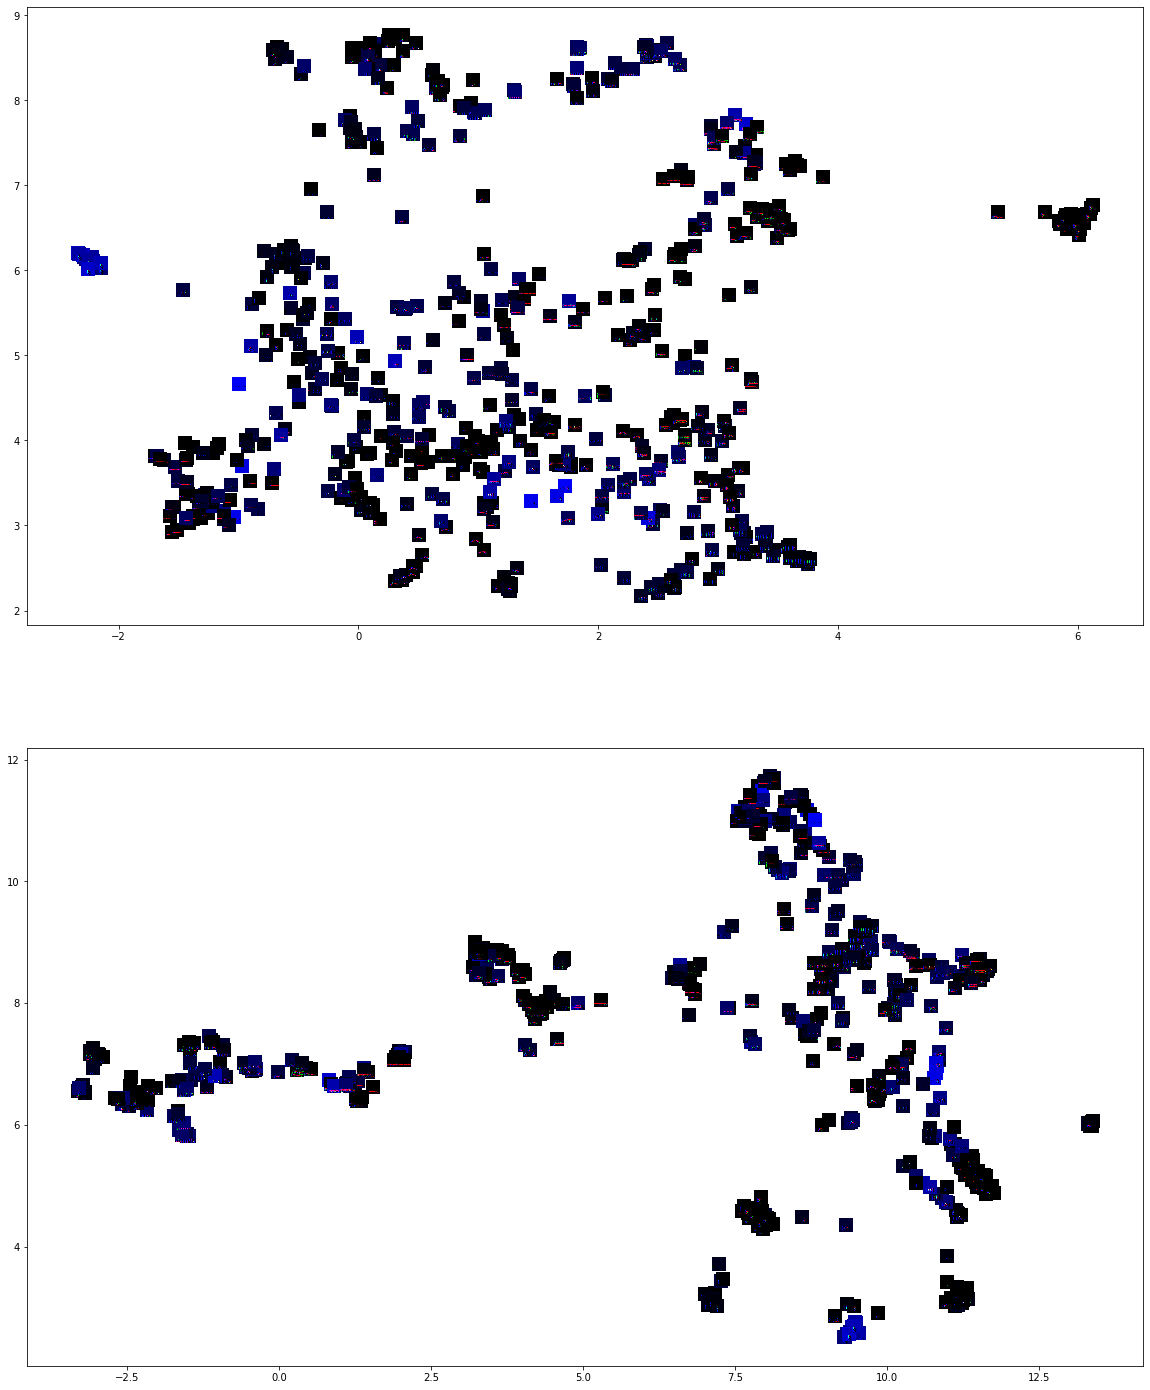

In [7]:
b, m = scatter_plots(baseline, 
                     meta, 
                     test, 
                     True, 
                     0.06, 
                     None, 
                     hdbscan.HDBSCAN, 
                     min_cluster_size=int(params['PARAMS_MODEL']['N_SHOT']+params['PARAMS_MODEL']['N_QUERY']), 
                     prediction_data=True)

### Plot performances metrics

In [8]:
df1 = pd.read_csv('models/measurements/5-ways-5-shots-20epochs-20iterations.csv')
df2 = pd.read_csv('models/measurements/5-ways-5-shots-20epochs-20iterations-aug.csv')

In [9]:
df1.head(1)

,Clusters,Accuracy,NMI,ARI,DBCV
0,17,0.69103,0.846075,0.565093,-0.354714


In [10]:
result = df1.where(df1.Clusters == df1.Clusters.mode()[0]).dropna()
result.where(result.DBCV == result.DBCV.max()).dropna()

,Clusters,Accuracy,NMI,ARI,DBCV
16,19.0,0.766082,0.868151,0.684299,-0.092029


In [11]:
df2.head(1)

,Clusters,Accuracy,NMI,ARI,DBCV
0,17,0.69103,0.846075,0.565093,-0.354714


In [12]:
result = df2.where(df2.Clusters == df2.Clusters.mode()[0]).dropna()
result.where(result.DBCV == result.DBCV.max()).dropna()

,Clusters,Accuracy,NMI,ARI,DBCV
16,19.0,0.738579,0.863712,0.66298,-0.065331


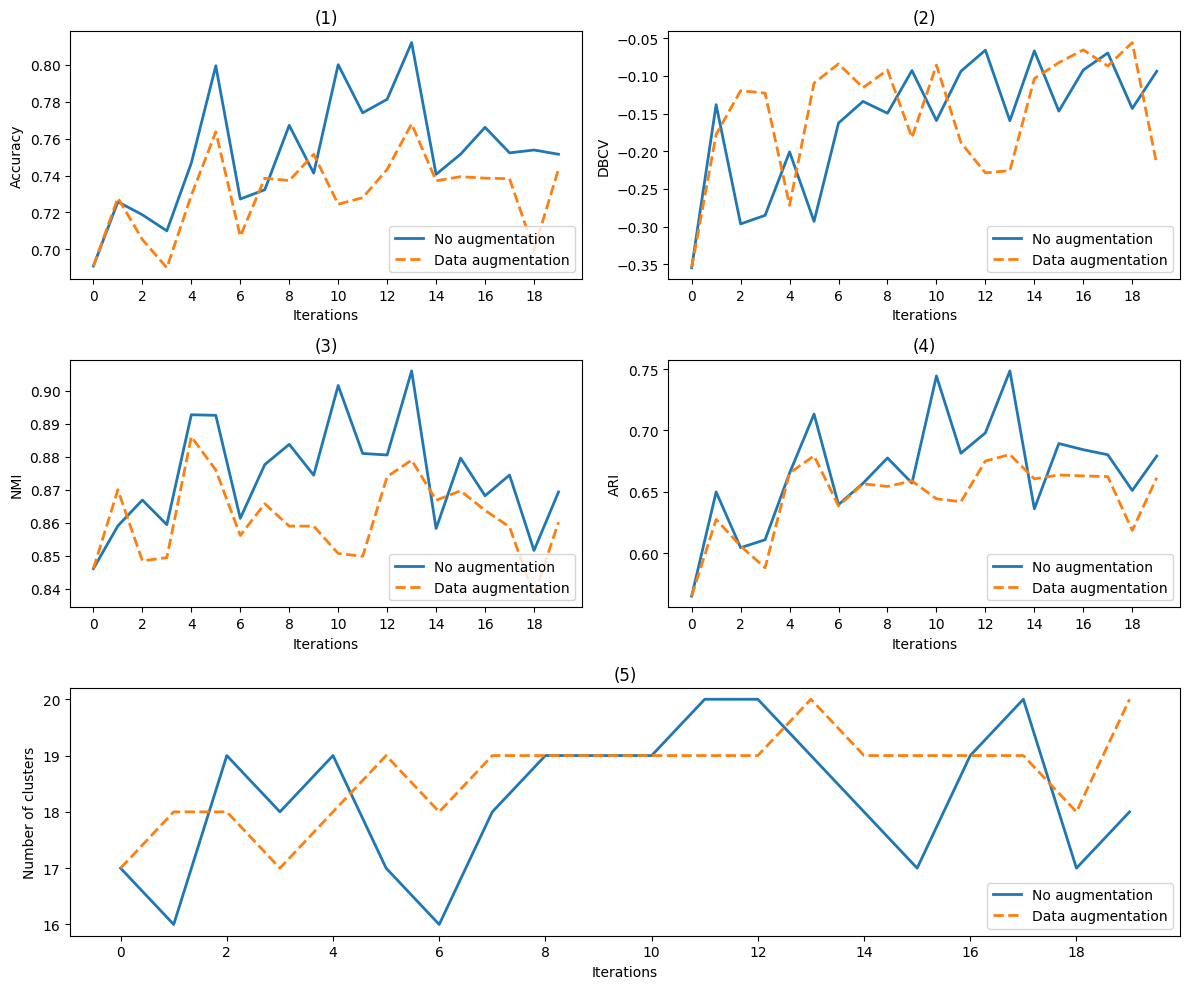

In [13]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(3,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])

iterations = range(0,20,2)

ax1.set_title('(1)')
ax1.plot(df1['Accuracy'].to_numpy(), label='No augmentation', linewidth=2)
ax1.plot(df2['Accuracy'].to_numpy(), label='Data augmentation', linewidth=2, linestyle='dashed')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(iterations)
ax1.legend(loc='lower right')

ax2.set_title('(2)')
ax2.plot(df1['DBCV'].to_numpy(), label='No augmentation', linewidth=2)
ax2.plot(df2['DBCV'].to_numpy(), label='Data augmentation', linewidth=2, linestyle='dashed')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('DBCV')
ax2.set_xticks(iterations)
ax2.legend(loc='lower right')

ax3.set_title('(3)')
ax3.plot(df1['NMI'].to_numpy(), label='No augmentation', linewidth=2)
ax3.plot(df2['NMI'].to_numpy(), label='Data augmentation', linewidth=2, linestyle='dashed')
ax3.set_xlabel('Iterations')
ax3.set_ylabel('NMI')
ax3.set_xticks(iterations)
ax3.legend(loc='lower right')

ax4.set_title('(4)')
ax4.plot(df1['ARI'].to_numpy(), label='No augmentation', linewidth=2)
ax4.plot(df2['ARI'].to_numpy(), label='Data augmentation', linewidth=2, linestyle='dashed')
ax4.set_xlabel('Iterations')
ax4.set_ylabel('ARI')
ax4.set_xticks(iterations)
ax4.legend(loc='lower right');

ax5.set_title('(5)')
ax5.plot(df1['Clusters'].to_numpy(), label='No augmentation', linewidth=2)
ax5.plot(df2['Clusters'].to_numpy(), label='Data augmentation', linewidth=2, linestyle='dashed')
ax5.set_xlabel('Iterations')
ax5.set_ylabel('Number of clusters')
ax5.set_xticks(iterations)
ax5.legend(loc='lower right')

plt.tight_layout()
# plt.savefig('mec.png');